# Mutation Datasets Preprocessing

This notebook preprocesses four mutation variant datasets for downstream analysis. For each dataset, we extract coding sequence (CDS) context from reference genome annotations, annotate variants with transcript information, codon changes, and amino acid translations, and save the processed data in a standardized format.

## Required Pre-processing Steps

Before generation the mutation sequences for zero-shot benchmarks, ensure that the following files are downloaded/processed and saved at `/data/ncbi`

#### 1. Open-source Data Download


##### Reference Files
| File | Origin |
|----------------|-------- |
| `hg19.fa` | [Download](https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz) |
| `hg38.fa` | [Download](https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz) |

##### Annotation Files

| Annotation File | Origin | Table |
|----------------|--------|-------|
| `gencode.v47lift37.basic.annotation.gtf` | [GENCODE Release 47lift37](https://www.gencodegenes.org/human/release_47lift37.html) | - |
| `ucsc_gencodev32_hg38.tsv` | [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables) | `wgEncodeGencodeCompV32` |
| `ucsc_refseq_hg38.tsv` | [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables) | `ncbiRefSeq` |
| `ucsc_refseq_hist_hg38.tsv` | [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables) | `ncbiRefSeqHistorical` |

##### Variant Files

| Variant File | Source | URL | Notes |
|--------------|--------|-----|-------|
| `asd_discov` | [Zhou et al. 2022](https://www.nature.com/articles/s41588-022-01148-2) | [Download](https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-022-01148-2/MediaObjects/41588_2022_1148_MOESM5_ESM.xlsx) | Supplementary Table 5 |
| `asd_rep` | [Zhou et al. 2022](https://www.nature.com/articles/s41588-022-01148-2) | [Download](https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-022-01148-2/MediaObjects/41588_2022_1148_MOESM6_ESM.xlsx) | Supplementary Table 6 |
| `ddd_other` | [Zhou et al. 2022](https://www.nature.com/articles/s41588-022-01148-2) | [Download](https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-022-01148-2/MediaObjects/41588_2022_1148_MOESM7_ESM.xlsx) | Supplementary Table 7 |
| `AlphaMissense ClinVar` | [Cheng et al. 2023](https://www.science.org/doi/10.1126/science.adg7492) | [Download](https://www.science.org/doi/suppl/10.1126/science.adg7492/suppl_file/science.adg7492_data_s1_to_s9.zip) | Data S5 |
| `AlphaMissense CancerHotspot` | [Cheng et al. 2023](https://www.science.org/doi/10.1126/science.adg7492) | [Download](https://www.science.org/doi/suppl/10.1126/science.adg7492/suppl_file/science.adg7492_data_s1_to_s9.zip) | Data S6 |

##### ClinVar Synonymous Matching Features

| File | Source | URL |
|------|--------|-----|
| `hg38.phyloP447way.bw` | UCSC Genome Browser | [Download](https://hgdownload.soe.ucsc.edu/goldenPath/hg38/phyloP447way/hg38.phyloP447way.bw) |
| `ucsc_pliByGene_hg38.tsv` | UCSC Genome Browser → Table Browser | [Download](https://genome.ucsc.edu/cgi-bin/hgTables) (table: `pliByGene`) |
| `variant_summary.txt.gz` | NCBI ClinVar (FTP) | [Download](https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz) |

#### 2. Data Scripts

Before running this notebook, ensure the following preprocessing scripts have been executed:

| File | Purpose | How to Generate |
|------|---------|-----------------|  
| `codon_counts_nopathogen.json` | Codon counts by taxonomic group (used for codon frequency features) | Run `python data_scripts/check_codon_frequency.py` after completing NCBI preprocessing in `data_scripts/data_curation/`. Place or symlink the produced file at `/data/ncbi/codon_counts_nopathogen.json`. |
| `gencode.v47lift37.basic.annotation.processed.tsv` | Processed GTF annotation with CDS coordinates | Run `python data_scripts/process_gtf.py` on the downloaded GENCODE GTF file `gencode.v47lift37.basic.annotation.gtf`. |


## Table of Contents

| Section | Dataset | Description | Required Data Files |
|---------|---------|-------------|---------------------|
| **1** | [DDD / ASD Dataset](#1-ddd-asd-dataset) | Developmental disorder and autism spectrum disorder variants | `ddd_asd_zhouetal/asd_discov.csv`<br>`ddd_asd_zhouetal/asd_rep.csv`<br>`ddd_asd_zhouetal/ddd_other.csv`<br>`gencode.v47lift37.basic.annotation.processed.tsv`<br>`alphamissense_data/AlphaMissense_hg19.tsv.gz`<br>`reference/hg19/hg19.fa` |
| **2** | [ClinVar AlphaMissense](#2-clinvar-alphamissense-dataset) | ClinVar missense variants with AlphaMissense pathogenicity predictions | `alphamissense_data/alphamissense_clinvar.csv`<br>`ucsc_gencodev32_hg38.tsv`<br>`hg38/hg38.fa` |
| **3** | [Cancer Hotspot](#3-cancer-hotspot) | Cancer hotspot mutations with AlphaMissense scores | `alphamissense_data/alphamissense_cancer_hotspot.csv`<br>`ucsc_gencodev32_hg38.tsv`<br>`reference/hg38/hg38.fa` |
| **4** | [ClinVar Synonymous](#4-clinvar-synonymous) | Extract synonymous variants from ClinVar (benign and pathogenic labels) with optional additional features | `clinvar_syn/variant_summary.txt.gz`<br>`clinvar_syn/ucsc_refseq_hg38.tsv`<br>`clinvar_syn/ucsc_refseq_hist_hg38.tsv`<br>`reference/hg38/hg38.fa` |

---


# Imports and Paths setup

In [ ]:
# Uncomment to install PyBigWig
!pip install  pyBigWig

In [ ]:
import ast
import json
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyBigWig
import pyfaidx
import seaborn as sns
from Bio.Seq import Seq
from matplotlib.ticker import LogLocator
from tqdm import tqdm


warnings.filterwarnings("ignore")

Before setting the `DATA_DIR` path, ensure the following directory structure (containing the files from the required pre-processing steo) is in place:

```
📁 DATA_DIR/
├── 📁 alphamissense_data/
│   ├── AlphaMissense_hg19.tsv.gz
│   ├── alphamissense_cancer_hotspot.csv
│   └── alphamissense_clinvar.csv
├── 📁 ddd_asd_zhouetal/
│   ├── asd_discov.csv
│   ├── asd_rep.csv
│   └── ddd_other.csv
├── 📁 clinvar_syn/
│   ├── variant_summary.txt.gz
│   ├── ucsc_refseq_hg38.tsv
│   └── ucsc_refseq_hist_hg38.tsv
├── 📁 reference/
│   ├── hg19/
│   │   ├── hg19.fa
│   │   └── hg19.fa.fai
│   └── hg38/
│       ├── hg38.fa
│       └── hg38.fa.fai
├── 📄 codon_counts_nopathogen.json
├── 📄 gencode.v47lift37.basic.annotation.processed.tsv
├── 📄 ucsc_gencodev32_hg38.tsv
├── 📄 ucsc_pliByGene_hg38.tsv
└── 📄 hg38.phyloP447way.bw
```


In [4]:
DATA_DIR = "/data/ncbi/"  # set this to the path of your data directory

OUTPUT_DIR = "/data/processed/mutation_datasets_latest"  # output directory where all processed datasets will be saved
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 0. Utils

In [5]:
dna_code = {
    "ATA": "I",
    "ATC": "I",
    "ATT": "I",
    "ATG": "M",
    "ACA": "T",
    "ACC": "T",
    "ACG": "T",
    "ACT": "T",
    "AAC": "N",
    "AAT": "N",
    "AAA": "K",
    "AAG": "K",
    "AGC": "S",
    "AGT": "S",
    "AGA": "R",
    "AGG": "R",
    "CTA": "L",
    "CTC": "L",
    "CTG": "L",
    "CTT": "L",
    "CCA": "P",
    "CCC": "P",
    "CCG": "P",
    "CCT": "P",
    "CAC": "H",
    "CAT": "H",
    "CAA": "Q",
    "CAG": "Q",
    "CGA": "R",
    "CGC": "R",
    "CGG": "R",
    "CGT": "R",
    "GTA": "V",
    "GTC": "V",
    "GTG": "V",
    "GTT": "V",
    "GCA": "A",
    "GCC": "A",
    "GCG": "A",
    "GCT": "A",
    "GAC": "D",
    "GAT": "D",
    "GAA": "E",
    "GAG": "E",
    "GGA": "G",
    "GGC": "G",
    "GGG": "G",
    "GGT": "G",
    "TCA": "S",
    "TCC": "S",
    "TCG": "S",
    "TCT": "S",
    "TTC": "F",
    "TTT": "F",
    "TTA": "L",
    "TTG": "L",
    "TAC": "Y",
    "TAT": "Y",
    "TAA": "*",
    "TAG": "*",
    "TGC": "C",
    "TGT": "C",
    "TGA": "*",
    "TGG": "W",
}


def translate(seq):
    """
    Translate an RNA sequence into a protein sequence.
    """
    protein = ""
    # Process the RNA sequence three nucleotides (codon) at a time.
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i : i + 3]
        # Look up the codon in the genetic code dictionary.
        amino_acid = dna_code.get(codon, "?")
        protein += amino_acid
    return protein


def reverse_complement_dna(seq):
    """
    Return the reverse complement of a DNA sequence.

    Parameters:
        seq (str): A DNA sequence with uppercase letters only (e.g., "ATCG").

    Returns:
        str: The reverse complement DNA sequence.

    Raises:
        KeyError: If the sequence contains lowercase letters or invalid characters.
    """
    complement = {"A": "T", "T": "A", "G": "C", "C": "G", "N": "N"}
    return "".join(complement[base] for base in seq[::-1])


def process_gtf(gtf_path, fasta_path):
    """
    Build coding sequences (CDS) for transcripts from a a gtf annotation file
    and a reference FASTA file.
    """
    gtf = pd.read_csv(gtf_path, sep="\t")
    if "#name" in gtf.columns:
        gtf = gtf.rename({"#name": "name"}, axis=1)
    gtf = (
        gtf.loc[gtf["cdsStart"] != gtf["cdsEnd"]].reset_index(drop=True).copy()
    )  # keep transcripts with a non‑empty coding region

    gtf["exonStarts_arr"] = gtf["exonStarts"].map(lambda x: ast.literal_eval(x))
    gtf["exonEnds_arr"] = gtf["exonEnds"].map(lambda x: ast.literal_eval(x))
    fasta = {}
    with pyfaidx.Fasta(fasta_path) as f:
        # Get available chromosomes in the FASTA file
        available_chroms = set(f.keys())
        # Filter GTF to only include chromosomes present in FASTA
        gtf_chroms = set(gtf["chrom"].unique())
        missing_chroms = gtf_chroms - available_chroms
        if missing_chroms:
            print(
                f"Warning: {len(missing_chroms)} chromosome(s) in GTF not found in FASTA, filtering them out: {sorted(missing_chroms)}"
            )
            gtf = gtf[gtf["chrom"].isin(available_chroms)].reset_index(drop=True).copy()
        # Load chromosome sequences
        for chrom in gtf["chrom"].unique():
            fasta[chrom] = f[chrom][
                :
            ].seq.upper()  #  load entire chrom sequence to uppercase and store in fasta[chrom] for fast slicing.
    cds_starts = []
    cds_ends = []
    lengths = []
    seqs = []
    for i in tqdm(
        range(gtf.shape[0]), desc="Processing transcripts", total=gtf.shape[0]
    ):  # loop through each transcript in the gtf file
        t = gtf.iloc[i]
        chrom = t["chrom"]
        cds_s = []
        cds_e = []
        cs, ce = t[["cdsStart", "cdsEnd"]]  # These are 0-based coordinates
        length = 0
        curr_seq = []
        for a, b in zip(t["exonStarts_arr"], t["exonEnds_arr"]):  # combine all exons regions for this transcript
            v1 = max(a, cs)  # clip exons to the coding region (ignore UTRs)
            v2 = min(b, ce)
            if v1 < v2:  # record the sequence string if it overlaps with the coding region
                cds_s.append(v1)
                cds_e.append(v2)
                length += v2 - v1
                curr_seq.append(fasta[chrom][v1:v2])
        # save the cds starts, ends, and length for this transcript
        cds_starts.append(tuple(cds_s))
        cds_ends.append(tuple(cds_e))
        lengths.append(length)
        # Get the joined CDS sequence in the forward direction (as it is build from the reference FASTA)
        curr_seq = "".join(curr_seq)
        if t["strand"] == "-":
            # reverse‑complement to get the seequence in the gene direction (5'→3')
            curr_seq = reverse_complement_dna(curr_seq)
        seqs.append(curr_seq)
    # Build the the processed transcript table with coding sequence information for each transcript
    gtf["cds_starts"] = cds_starts
    gtf["cds_ends"] = cds_ends
    gtf["cds_length"] = lengths
    gtf["cds"] = seqs  # sequence is strand-aware (always gene 5'->3')

    gtf_s = gtf[
        ["name", "chrom", "strand", "cdsStart", "cdsEnd", "cds_starts", "cds_ends", "cds_length", "cds"]
    ].copy()
    gtf_s["name"] = gtf_s["name"].str.split(".").str[0]
    # Sort transcripts by chromosome, start, and end coordinates, they're in the forward direction and 0-based.
    gtf_s = gtf_s.sort_values(by=["chrom", "cdsStart", "cdsEnd"]).reset_index(drop=True).copy()

    return gtf_s, fasta


def process_a_chrom(chrom_variants, chrom_refseq, return_alt_cds=False):
    """
    Annotate a single nucleotide variant with transcript CDS context.
        - Locate its position within the coding sequence (0-based coordinate),
        - extract the ref codon and build the alt codon,
        - translate codons to amino acids,
        - optionally, build the full alternate CDS with the mutation.

    ## Notes: The output columns are:
       - pos: 1-based (forward direction, genomic coordinates)
       - ref: genomic ref allele (as in the reference genome, forward orientation)
       - alt: genomic alt allele (as in the reference genome, forward orientation)
       - cdsStart: 0-based genomic start of CDS, half-open interval; genomic axis.
       - cdsEnd: 0-based genomic end of CDS, half-open interval; genomic axis.
       - var_rel_dist_in_cds: 0-based index within the CDS in transcript 5'->3' orientation (strand-aware).
       - ref_seq: full CDS string in transcript 5'->3' orientation
       - ref_codon: codon from ref_seq at the variant position; strand-aware.
       - alt_codon: codon after single-base change; strand-aware.
       - ref_aa: ref amino acid at the variant position
       - alt_aa: alt amino acid at the variant position
       - alt_seq (if set): full alt CDS after the single-base change, transcript 5'->3' orientation; strand-aware.
       - codon_position: 0-based codon index within CDS.

    """
    # normalize alleles;
    chrom_variants["ref"] = chrom_variants["ref"].str.upper()
    chrom_variants["alt"] = chrom_variants["alt"].str.upper()

    var_ids = chrom_variants["variant_id"].values
    var_pos = (
        chrom_variants["pos"].values - 1
    )  # Convert to 0-based - mutations are always reported in 1-based coordinates
    var_ref = chrom_variants["ref"].values  # reference allele
    var_alt = chrom_variants["alt"].values  # alternate allele
    chrom = chrom_refseq.iloc[0]["chrom"]

    # CDS processed using `process_gtf`` function
    cds_strands = chrom_refseq["strand"].values  # strand of the coding sequence
    cds_starts = chrom_refseq["cdsStart"].values
    cds_ends = chrom_refseq["cdsEnd"].values
    cds_lengths = chrom_refseq["cds_length"].values
    rec_cds_starts = chrom_refseq[
        "cds_starts"
    ].values  # List of exon starts within the CDS region for all transcripts.
    rec_cds_ends = chrom_refseq["cds_ends"].values  # List of exon ends within the CDS region for all transcripts.
    rec_cds = chrom_refseq["cds"].values  # CDS sequence - strand-aware (always gene 5'->3')
    rec_names = chrom_refseq["name"].values

    # Find transcripts (CDS regions)that overlap the variant position
    # sorted variant positions to find, per transcript,
    # var_pos[s1[j]:ss2[j]] includes all variants with pos in [cdsStart[j], cdsEnd[j]) for transcript j.
    s1 = np.searchsorted(var_pos, cds_starts, side="left")
    s2 = np.searchsorted(var_pos, cds_ends, side="right")
    results = []

    # Loop through each transcript j (CDS region) and get information for all overlapping variants.
    for j, (ss1, ss2) in enumerate(zip(s1, s2)):
        curr_starts = rec_cds_starts[j]  # CDS starts boundaries for transcript j.
        curr_ends = rec_cds_ends[j]  # CDS ends boundaries for transcript j.
        # Sanity checks on CDS sequence for this transcript
        assert cds_lengths[j] == len(rec_cds[j]), f"CDS length mismatch for {rec_names[j]}"
        assert cds_lengths[j] % 3 == 0, f"CDS length not multiple of 3 for {rec_names[j]}"
        if ss1 < ss2:
            for i in range(ss1, ss2):  # loop through all variants in the CDS region for transcript j.
                pos = var_pos[i]
                curr_ref = var_ref[i]
                curr_alt = var_alt[i]
                # Calculate offset in CDS sequence - translate a genomic coordinate into a CDS relativeindex.
                offset = 0
                bound = False
                for a, b in zip(curr_starts, curr_ends):
                    if pos >= b:  # if the variant is after the end of the exon
                        offset += b - a  # Add length of complete exon
                    elif a <= pos < b:
                        offset += pos - a
                        bound = True  # the variant is within this exon
                        break
                if bound:
                    if cds_strands[j] == "-":
                        # Handle reverse strand
                        offset = cds_lengths[j] - 1 - offset  # Convert to reverse strand position
                        ref_codon = rec_cds[j][offset // 3 * 3 : offset // 3 * 3 + 3]
                        # Check if the reference base in ref codon is the reverse complement of the variant reference allele from the reference FASTA.
                        assert rec_cds[j][offset] == reverse_complement_dna(curr_ref), f"-, {ref_codon} {var_ids[i]}"
                        # Build the alternate codon by replacing the reference base with the alternate allele.
                        alt_codon = (
                            ref_codon[: offset % 3] + reverse_complement_dna(curr_alt) + ref_codon[offset % 3 + 1 :]
                        )
                        results.append(
                            [
                                chrom,
                                pos,
                                f"{chrom}_{pos + 1}_{curr_ref}_{curr_alt}",
                                curr_ref,
                                curr_alt,
                                rec_names[j],
                                cds_starts[j],
                                cds_ends[j],
                                cds_strands[j],
                                offset,
                                rec_cds[j],
                                ref_codon,
                                alt_codon,
                                translate(ref_codon),
                                translate(alt_codon),
                            ]
                        )

                        if return_alt_cds:
                            alt_cds = rec_cds[j][:offset] + reverse_complement_dna(curr_alt) + rec_cds[j][offset + 1 :]
                            results[-1].append(alt_cds)
                    else:
                        # Handle forward strand
                        ref_codon = rec_cds[j][offset // 3 * 3 : offset // 3 * 3 + 3]
                        assert rec_cds[j][offset] == curr_ref, f"+, {ref_codon} {var_ids[i]}"
                        alt_codon = ref_codon[: offset % 3] + curr_alt + ref_codon[offset % 3 + 1 :]

                        results.append(
                            [
                                chrom,
                                pos,
                                f"{chrom}_{pos + 1}_{curr_ref}_{curr_alt}",
                                curr_ref,
                                curr_alt,
                                rec_names[j],
                                cds_starts[j],
                                cds_ends[j],
                                cds_strands[j],
                                offset,
                                rec_cds[j],
                                ref_codon,
                                alt_codon,
                                translate(ref_codon),
                                translate(alt_codon),
                            ]
                        )

                        if return_alt_cds:
                            alt_cds = rec_cds[j][:offset] + curr_alt + rec_cds[j][offset + 1 :]
                            results[-1].append(alt_cds)

    columns = [
        "chrom",
        "pos",
        "variant_id",
        "ref",
        "alt",
        "tx_name",
        "cdsStart",
        "cdsEnd",
        "tx_strand",
        "var_rel_dist_in_cds",
        "ref_seq",
        "ref_codon",
        "alt_codon",
        "ref_aa",
        "alt_aa",
    ]
    if return_alt_cds:
        columns.append("alt_seq")

    if results:
        results = pd.DataFrame(results)
        results.columns = columns
        results["pos"] += 1  # Convert back to 1-based
        results["codon_position"] = results["var_rel_dist_in_cds"] // 3
    else:
        # Create empty DataFrame with correct columns
        results = pd.DataFrame(columns=columns)
        results["codon_position"] = pd.Series(dtype="int64")

    return results


def plot_transcript_distribution(variants):
    # Count transcripts per variant, then count how many variants fall in each bin
    counts_pl = pl.from_pandas(variants).group_by("variant_id").count().rename({"count": "n_transcripts"})
    hist_pl = counts_pl.group_by("n_transcripts").count().rename({"count": "n_variants"}).sort("n_transcripts")
    df = hist_pl.to_pandas().astype({"n_transcripts": "int64", "n_variants": "int64"})
    plt.figure(figsize=(20, 4))
    ax = sns.barplot(data=df, x="n_transcripts", y="n_variants", color="#4c5a88")
    ax.set_xlabel("Number of transcripts associated with a single variant")
    ax.set_ylabel("Number of unique variants")
    ax.set_title("Distribution of transcripts per variant")
    ax.set_yscale("log")
    ax.yaxis.set_major_locator(LogLocator(base=10))  # 10^k ticks                        # log-scale Y
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(
                f"{int(h):,}",
                (p.get_x() + p.get_width() / 2, h),
                ha="center",
                va="bottom",
                fontsize=9,
                xytext=(0, 3),
                textcoords="offset points",
            )
    sns.despine()
    plt.tight_layout()
    plt.show()


def check_mutation_positions(df: pd.DataFrame, adjusted_context_length: int) -> pd.DataFrame:
    """
    Check if the mutation positions are within the bounds of the coding sequence.
    adjusted_context_length = max_length - 2 (for [CLS] and [SEP])
    """

    def _check(row):
        ref_seq = row["ref_seq"]
        codon_pos = int(row["codon_position"])
        total_codons = (len(ref_seq) // 3) if isinstance(ref_seq, str) else 0
        out = {
            "id": row.get("id", None),
            "variant_id": row.get("variant_id", None),
            "total_codons": total_codons,
            "codon_position": codon_pos,
            "in_bounds": codon_pos < total_codons,
            "needs_centering": total_codons > adjusted_context_length,
            "out_of_bounds": codon_pos >= adjusted_context_length,
        }
        return pd.Series(out)

    return df.apply(_check, axis=1)


def get_reverse_complement(seq):
    """Get reverse complement of a sequence"""
    complement = {"A": "T", "T": "A", "G": "C", "C": "G", "N": "N"}
    return "".join(complement[base] for base in seq[::-1].upper())


def extract_cds_sequence(row, fasta):
    """Extract CDS sequence for a transcript based on exon coordinates and CDS boundaries."""
    chrom = row["chrom"]
    strand = row["strand"]
    cds_start = row["cdsStart"]
    cds_end = row["cdsEnd"]

    # Parse exon coordinates
    exon_starts = [int(x) for x in row["exonStarts"].rstrip(",").split(",")]
    exon_ends = [int(x) for x in row["exonEnds"].rstrip(",").split(",")]

    # Extract CDS sequence from exons
    cds_sequence = ""

    for start, end in zip(exon_starts, exon_ends):
        # Find overlap between exon and CDS
        overlap_start = max(start, cds_start)
        overlap_end = min(end, cds_end)

        if overlap_start < overlap_end:
            # Extract sequence from this exon segment
            seq = str(fasta[chrom][overlap_start:overlap_end]).upper()
            cds_sequence += seq

    # Reverse complement if on negative strand
    if strand == "-":
        cds_sequence = get_reverse_complement(cds_sequence)

    return cds_sequence


def process_dset(dset, refseq, remove_non_pli=False):
    """
    Add additional features to the dataset including:
    - Amino acid translations
    - Codon frequency ratios
    - Gene names and pLI scores
    - PhyloP conservation scores
    - CDS offset fractions
    """
    # Add amino acid translations to the dataset
    dset = dset.with_columns(
        [
            pl.col("ref_codon")
            .map_elements(lambda x: str(Seq(x).translate()), return_dtype=pl.String)
            .alias("ref_aa"),
            pl.col("alt_codon")
            .map_elements(lambda x: str(Seq(x).translate()), return_dtype=pl.String)
            .alias("alt_aa"),
        ]
    )

    assert dset.filter(pl.col("ref_aa") != pl.col("alt_aa")).height == 0
    dset = dset.filter(pl.col("ref_aa") != "*")

    codon_freqs = json.load(open(f"{DATA_DIR}/codon_counts_nopathogen.json"))["Primates"]

    dset = dset.with_columns(
        pl.col("ref_codon").map_elements(lambda x: codon_freqs[x], return_dtype=pl.Float64).alias("ref_codon_freq")
    )
    dset = dset.with_columns(
        pl.col("alt_codon").map_elements(lambda x: codon_freqs[x], return_dtype=pl.Float64).alias("alt_codon_freq")
    )
    dset = dset.with_columns((pl.col("ref_codon_freq") / pl.col("alt_codon_freq")).log().alias("codon_freq_ratio"))

    tx_to_name = {row["name"]: row["name2"] for row in refseq.rows(named=True)}

    if "gene_name" not in dset.columns:
        dset = dset.with_columns(
            pl.col("tx").map_elements(lambda x: tx_to_name[x], return_dtype=pl.String).alias("gene_name")
        )
    pli = pl.read_csv(f"{DATA_DIR}/ucsc_pliByGene_hg38.tsv", separator="\t")
    gene_to_pli = {row["geneName"]: row["_pli"] for row in pli.rows(named=True)}
    dset = dset.with_columns(
        pl.col("gene_name").map_elements(lambda x: gene_to_pli.get(x, -1000), return_dtype=pl.Float64).alias("pli")
    )

    if remove_non_pli:
        dset = dset.filter(pl.col("pli") != -1000)
    dset = dset.with_columns((pl.col("pli") * 10).cast(pl.Int32).alias("pli_bin"))

    bw = pyBigWig.open(f"{DATA_DIR}/hg38.phyloP447way.bw")
    phylop = []
    for row in tqdm(dset.rows(named=True)):
        phylop.append(bw.values(row["chrom"], row["pos"] - 1, row["pos"])[0])
    dset = dset.with_columns(pl.Series(values=phylop, name="phylop").fill_nan(-1000))
    dset = dset.with_columns(pl.col("phylop").round().cast(pl.Int32).alias("phylop_bin"))

    if "cds_offset_frac" not in dset.columns:
        dset = dset.with_columns(pl.col("ref_seq").str.len_chars().alias("cds_length"))
        dset = dset.with_columns((pl.col("var_rel_dist_in_cds") / pl.col("cds_length")).alias("cds_offset_frac"))
    dset = dset.with_columns((pl.col("cds_offset_frac") * 10).cast(pl.Int32).alias("cds_offset_frac_bin"))

    return dset

# 1. DDD-ASD Dataset

In [5]:
dataset_name = "ddd_asd_zhouetal"
# Load ASD variants
data = pd.read_csv(f"{DATA_DIR}/{dataset_name}/asd_discov.csv")
data1 = pd.read_csv(f"{DATA_DIR}/{dataset_name}/asd_rep.csv")
data = pd.concat([data, data1])
print("ASD variants:")
display(data.head(2))
# Load DDD variants
ddd_variants = pd.read_csv(f"{DATA_DIR}/{dataset_name}/ddd_other.csv")
print("DDD variants:")
display(ddd_variants.head(2))

ASD variants:


,Cohort,IID,Sex,Pheno,DNASource,VarID,Chrom,Position,Ref,Alt,...,pExt_HBDR,HGNCv24,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,DP_AL,DP_DG,DP_DL
0,SPARK,SP0012309,Male,Affected,Saliva,1:874817:C:T,1,874817,C,T,...,1,SAMD11,0.0008,0,0,0,-29,-3,23,-25
1,MSSNG,MSSNG00218-003,Male,Affected,Blood,1:878673:A:T,1,878673,A,T,...,1,SAMD11,0.0086,0,0,0,-31,2,-36,36


DDD variants:


,Cohort,IID,Sex,Pheno,VarID,Chrom,Position,Ref,Alt,Context,...,pExt_HBDR,HGNCv24,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,DP_AL,DP_DG,DP_DL
0,GDX,GDX_100016,Male,Affected,1:154991112:C:T,1,154991112,C,T,GCG>GTG,...,0.499,DCST2,0,0,0,0,-10,-25,-3,-38
1,GDX,GDX_100016,Male,Affected,19:40366418:C:T,19,40366418,C,T,GCG>GTG,...,1,FCGBP,0.0002,0,0,0,-39,5,28,5


In [6]:
# Check for non SNVs
(ddd_variants["Ref"].str.len() != 1).sum()

2933

In [7]:
# Fitler SNVs in ASD and DDD datasets
data = data.loc[(data["Ref"].str.len() == 1) & (data["Alt"].str.len() == 1)].copy()
asd_variants = data[data["Pheno"] == "Affected"]
ct_variants = data[data["Pheno"] == "Unaffected"]

ddd_variants = ddd_variants.loc[(ddd_variants["Ref"].str.len() == 1) & (ddd_variants["Alt"].str.len() == 1)].copy()

print("ASD variants counts:")
print(data["Pheno"].value_counts())
print("\nDDD variants counts:")
print(ddd_variants["Pheno"].value_counts())

ASD variants counts:
Pheno
Affected      21971
Unaffected     7123
Uncertain        93
Name: count, dtype: int64

DDD variants counts:
Pheno
Affected    41616
Name: count, dtype: int64


In [8]:
# Group all variants
variants = []
for classification, dset in zip(["asd", "control", "ddd"], [asd_variants, ct_variants, ddd_variants]):
    temp = dset[["VarID", "Chrom", "Position", "Ref", "Alt", "Pheno"]].copy()
    temp["classification"] = classification
    variants.append(temp)
variants = pd.concat(variants)

# Rename columns
variants = variants.rename(
    columns={"VarID": "variant_id", "Chrom": "chrom", "Position": "pos", "Ref": "ref", "Alt": "alt"}
)
variants["chrom"] = "chr" + variants["chrom"].astype(str)
variants = variants.sort_values(by=["chrom", "pos"]).reset_index(drop=True).copy()

variants.head(2)

,variant_id,chrom,pos,ref,alt,Pheno,classification
0,1:871216:G:A,chr1,871216,G,A,Affected,ddd
1,1:874817:C:T,chr1,874817,C,T,Affected,asd


In [9]:
# Get the reference sequence and CDS context annotation of the variants from the GTF and FASTA files
assembly = "hg19"
all_results = []
gtf_s, fasta = process_gtf(
    f"{DATA_DIR}/gencode.v47lift37.basic.annotation.processed.tsv", f"{DATA_DIR}/reference/{assembly}/hg19.fa"
)
print(f"Processed {gtf_s.shape[0]} GTF CDS sequences")
display(gtf_s[["name", "chrom", "strand", "cdsStart", "cdsEnd", "cds_starts", "cds_ends", "cds_length"]].head(2))

Processing transcripts: 100%|██████████| 65158/65158 [00:14<00:00, 4392.38it/s]


Processed 65158 GTF CDS sequences


,name,chrom,strand,cdsStart,cdsEnd,cds_starts,cds_ends,cds_length
0,ENST00000641515,chr1,+,65564,70008,"(65564, 69036)","(65573, 70008)",981
1,ENST00000423372,chr1,-,138529,139309,"(138529,)","(139309,)",780


In [10]:
# Check for transcripts with CDS length not multiple of 3
gtf_s[gtf_s["cds_length"].astype(int) % 3 != 0][
    ["name", "chrom", "strand", "cdsStart", "cdsEnd", "cds_starts", "cds_ends", "cds_length"]
].head(2)

,name,chrom,strand,cdsStart,cdsEnd,cds_starts,cds_ends,cds_length
534,ENST00000332296,chr1,+,12853376,12856145,"(12853376, 12854063, 12855586, 12855845)","(12853663, 12854642, 12855834, 12856145)",1414
539,ENST00000235347,chr1,-,12952746,12955678,"(12952746, 12954416, 12955391, 12955461)","(12953305, 12954995, 12955460, 12955678)",1424


In [11]:
# Process variants per chromosome
## Filter sequences with CDS length not multiple of 3
gtf_s = gtf_s[gtf_s["cds_length"].astype(int) % 3 == 0]
chroms = variants["chrom"].unique()
for chrom in tqdm(chroms, desc="Processing chromosomes", total=len(chroms)):
    curr_variants = (
        variants[variants["chrom"] == chrom][["variant_id", "chrom", "pos", "ref", "alt"]].drop_duplicates().copy()
    )
    chrom_gtf = gtf_s[gtf_s["chrom"] == chrom]
    chrom_results = process_a_chrom(curr_variants, chrom_gtf, return_alt_cds=True)
    all_results.append(chrom_results)
all_results = pd.concat(all_results).reset_index(drop=True)
all_results["variant_id"] = all_results["variant_id"] + "_" + assembly
all_results = all_results.merge(
    variants.drop("variant_id", axis=1),
    left_on=["chrom", "pos", "ref", "alt"],
    right_on=["chrom", "pos", "ref", "alt"],
)
print(f"\n Processed {all_results.shape[0]} mutations with CDS context:")
cols_to_display = [
    "chrom",
    "pos",
    "variant_id",
    "ref",
    "alt",
    "tx_name",
    "cdsStart",
    "cdsEnd",
    "tx_strand",
    "var_rel_dist_in_cds",
    "ref_codon",
    "alt_codon",
    "ref_aa",
    "alt_aa",
    "codon_position",
    "Pheno",
    "classification",
]
display(all_results[cols_to_display].head(2))

Processing chromosomes: 100%|██████████| 23/23 [00:03<00:00,  7.11it/s]



 Processed 239974 mutations with CDS context:


,chrom,pos,variant_id,ref,alt,tx_name,cdsStart,cdsEnd,tx_strand,var_rel_dist_in_cds,ref_codon,alt_codon,ref_aa,alt_aa,codon_position,Pheno,classification
0,chr1,871216,chr1_871216_G_A_hg19,G,A,ENST00000616016,859811,879533,+,906,GAG,AAG,E,K,302,Affected,ddd
1,chr1,877862,chr1_877862_T_C_hg19,T,C,ENST00000616016,859811,879533,+,1546,CTG,CCG,L,P,515,Affected,ddd


In [12]:
# Ensure reference allele in fasta matches reference allele in variants
for i in range(variants.shape[0]):
    t = variants.iloc[i]
    variant_id = t["variant_id"]
    chrom = t["chrom"]
    pos = t["pos"]
    ref = t["ref"]
    hg19_ref = fasta[chrom][pos - 1]
    if hg19_ref != ref:
        print(f"Mismatch at {chrom}:{pos}, {ref} != {hg19_ref}, {variant_id}")

In [13]:
# Add variant type based on translated amino acid
all_results["variant_type"] = "synonymous"
all_results.loc[(all_results["ref_aa"] != all_results["alt_aa"]) & (all_results["alt_aa"] != "*"), "variant_type"] = (
    "missense"
)
all_results.loc[(all_results["ref_aa"] != all_results["alt_aa"]) & (all_results["alt_aa"] == "*"), "variant_type"] = (
    "ptv"
)
all_results.loc[(all_results["ref_aa"] == "*"), "variant_type"] = "in_stop"
all_results[cols_to_display + ["variant_type"]].head(2)

,chrom,pos,variant_id,ref,alt,tx_name,cdsStart,cdsEnd,tx_strand,var_rel_dist_in_cds,ref_codon,alt_codon,ref_aa,alt_aa,codon_position,Pheno,classification,variant_type
0,chr1,871216,chr1_871216_G_A_hg19,G,A,ENST00000616016,859811,879533,+,906,GAG,AAG,E,K,302,Affected,ddd,missense
1,chr1,877862,chr1_877862_T_C_hg19,T,C,ENST00000616016,859811,879533,+,1546,CTG,CCG,L,P,515,Affected,ddd,missense


In [14]:
all_results[["variant_type", "classification"]].value_counts()

variant_type  classification
missense      ddd               107438
              asd                46889
synonymous    ddd                28934
              asd                16758
missense      control            14930
ptv           ddd                14093
synonymous    control             5457
ptv           asd                 4547
              control              755
in_stop       ddd                   97
              asd                   50
              control               26
Name: count, dtype: int64

In [15]:
final_results = (
    all_results.groupby(["variant_id", "tx_name", "variant_type"])
    .agg(
        {
            col: "first" if col not in ["classification"] else lambda x: ",".join(sorted(set(x)))
            for col in all_results.columns
            if col not in ["variant_id", "tx_name", "variant_type"]
        }
    )
    .reset_index()
)

# Find rows where classification contains both control and (asd or ddd)
mask = final_results["classification"].str.contains("control") & (
    final_results["classification"].str.contains("asd") | final_results["classification"].str.contains("ddd")
)
final_results = final_results[~mask].reset_index(drop=True)
final_results = final_results.drop_duplicates(["variant_id", "ref_seq", "alt_seq", "ref_codon", "alt_codon"])
final_results.insert(0, "id", np.arange(final_results.shape[0]))
final_results[cols_to_display + ["variant_type"]].head(2)

,chrom,pos,variant_id,ref,alt,tx_name,cdsStart,cdsEnd,tx_strand,var_rel_dist_in_cds,ref_codon,alt_codon,ref_aa,alt_aa,codon_position,Pheno,classification,variant_type
0,chr10,100011447,chr10_100011447_C_T_hg19,C,T,ENST00000260702,100008677,100022776,-,1963,CGC,CAC,R,H,654,Affected,ddd,missense
1,chr10,100017561,chr10_100017561_C_G_hg19,C,G,ENST00000260702,100008677,100022776,-,1105,GGG,GCG,G,A,368,Affected,ddd,missense


In [16]:
final_results["variant_type"].value_counts()

variant_type
missense      127887
synonymous     41436
ptv            12328
in_stop          133
Name: count, dtype: int64

In [17]:
# Get both unique variants and total rows per group
variant_counts = (
    final_results.groupby(["classification", "variant_type"])
    .agg({"variant_id": ["nunique", "count"]})
    .rename(columns={"nunique": "unique_variants", "count": "total_rows"})
)
print(variant_counts)

                                 variant_id           
                            unique_variants total_rows
classification variant_type                           
asd            in_stop                   25         37
               missense               13343      35771
               ptv                      920       3034
               synonymous              5206      13239
asd,ddd        missense                 294       1087
               ptv                       58        312
               synonymous                62        136
control        in_stop                   10         19
               missense                4556      11998
               ptv                      200        533
               synonymous              1776       4420
ddd            in_stop                   44         77
               missense               26760      79031
               ptv                     2318       8449
               synonymous              9233      23641


In [18]:
af_hg19 = pl.read_csv(f"{DATA_DIR}/alphamissense_data/AlphaMissense_hg19.tsv.gz", separator="\t", skip_rows=3)
af_hg19 = af_hg19.rename({"#CHROM": "chrom", "POS": "pos", "REF": "ref", "ALT": "alt"})
af_hg19 = af_hg19.with_columns(
    pl.concat_str(
        [pl.col("chrom"), pl.col("pos").cast(str), pl.col("ref"), pl.col("alt"), pl.lit("hg19")], separator="_"
    ).alias("variant_id")
)
af_hg19 = af_hg19.with_columns(pl.col("transcript_id").str.split(".").list.first().alias("tx_name"))
af_hg19.head(2)

chrom,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,variant_id,tx_name
str,i64,str,str,str,str,str,str,f64,str,str,str
"""chr1""",69094,"""G""","""T""","""hg19""","""Q8NH21""","""ENST00000335137.3""","""V2L""",0.2937,"""benign""","""chr1_69094_G_T_hg19""","""ENST00000335137"""
"""chr1""",69094,"""G""","""C""","""hg19""","""Q8NH21""","""ENST00000335137.3""","""V2L""",0.2937,"""benign""","""chr1_69094_G_C_hg19""","""ENST00000335137"""


In [19]:
# Filter the ASD/DDD variants to alpha missense
missense_variants = pl.from_pandas(final_results.loc[final_results["variant_type"] == "missense"].copy())
missense_variants = (
    missense_variants.join(af_hg19, on=["variant_id", "tx_name"], how="left")
    .drop_nulls()
    .rename({"am_pathogenicity": "AlphaMissense"})
)
missense_variants.head(2)

id,variant_id,tx_name,variant_type,chrom,pos,ref,alt,cdsStart,cdsEnd,tx_strand,var_rel_dist_in_cds,ref_seq,ref_codon,alt_codon,ref_aa,alt_aa,alt_seq,codon_position,Pheno,classification,chrom_right,pos_right,ref_right,alt_right,genome,uniprot_id,transcript_id,protein_variant,AlphaMissense,am_class
i64,str,str,str,str,i64,str,str,i64,i64,str,i64,str,str,str,str,str,str,i64,str,str,str,i64,str,str,str,str,str,str,f64,str
0,"""chr10_100011447_C_T_hg19""","""ENST00000260702""","""missense""","""chr10""",100011447,"""C""","""T""",100008677,100022776,"""-""",1963,"""ATGGCGTGGTCCCCACCAGCCACCCTCTTT…","""CGC""","""CAC""","""R""","""H""","""ATGGCGTGGTCCCCACCAGCCACCCTCTTT…",654,"""Affected""","""ddd""","""chr10""",100011447,"""C""","""T""","""hg19""","""Q96JB6""","""ENST00000260702.3""","""R655H""",0.1004,"""benign"""
1,"""chr10_100017561_C_G_hg19""","""ENST00000260702""","""missense""","""chr10""",100017561,"""C""","""G""",100008677,100022776,"""-""",1105,"""ATGGCGTGGTCCCCACCAGCCACCCTCTTT…","""GGG""","""GCG""","""G""","""A""","""ATGGCGTGGTCCCCACCAGCCACCCTCTTT…",368,"""Affected""","""ddd""","""chr10""",100017561,"""C""","""G""","""hg19""","""Q96JB6""","""ENST00000260702.3""","""G369A""",0.1315,"""benign"""


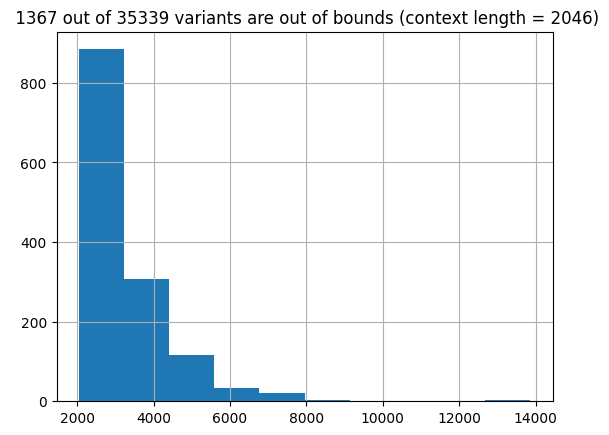

In [20]:
# Check for codons mutations out of bounds of the max context length
context_to_check = 2046
checks = check_mutation_positions(missense_variants.to_pandas(), context_to_check)
checks[checks["out_of_bounds"]].codon_position.hist()
plt.title(
    f" {checks['out_of_bounds'].sum()} out of {len(checks)} variants are out of bounds (context length = {context_to_check})"
)
plt.show()

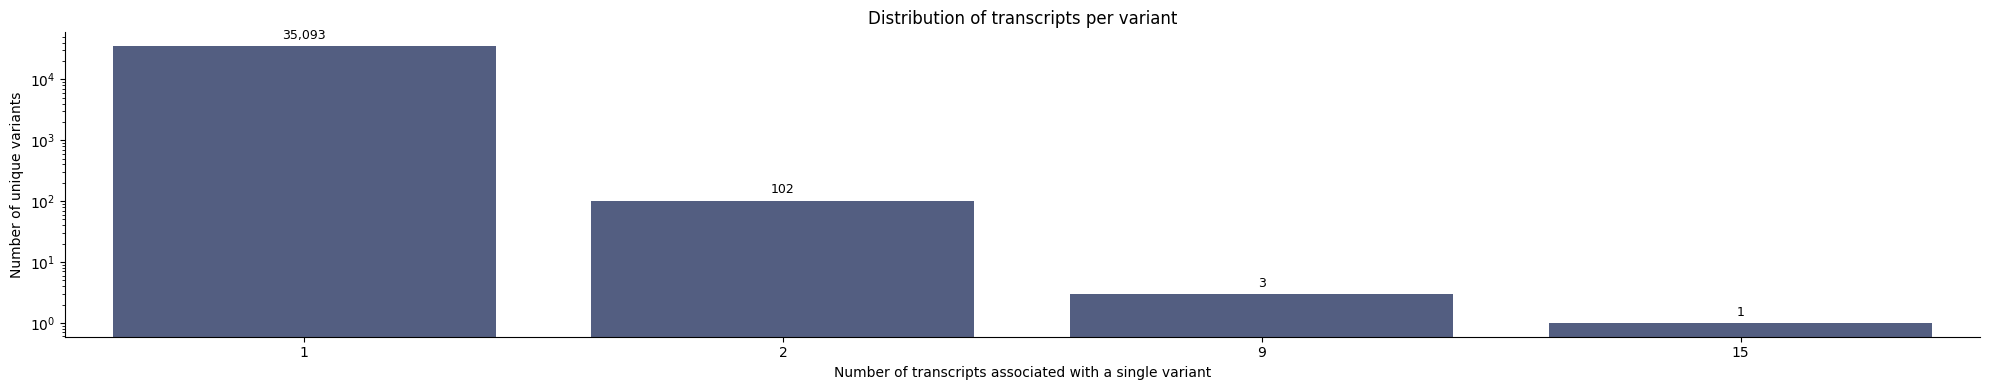

In [21]:
import matplotlib.pyplot as plt


# Count transcripts per variant, then count how many variants fall in each bin
counts_pl = missense_variants.group_by("variant_id").count().rename({"count": "n_transcripts"})
hist_pl = counts_pl.group_by("n_transcripts").count().rename({"count": "n_variants"}).sort("n_transcripts")
df = hist_pl.to_pandas().astype({"n_transcripts": "int64", "n_variants": "int64"})
plt.figure(figsize=(20, 4))
ax = sns.barplot(data=df, x="n_transcripts", y="n_variants", color="#4c5a88")
ax.set_xlabel("Number of transcripts associated with a single variant")
ax.set_ylabel("Number of unique variants")
ax.set_title("Distribution of transcripts per variant")
ax.set_yscale("log")
ax.yaxis.set_major_locator(LogLocator(base=10))  # 10^k ticks                        # log-scale Y
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(
            f"{int(h):,}",
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom",
            fontsize=9,
            xytext=(0, 3),
            textcoords="offset points",
        )
sns.despine()
plt.tight_layout()
plt.show()

In [22]:
missense_variants.shape

(35339, 31)

In [23]:
missense_variants.write_csv(f"{OUTPUT_DIR}/ddd_asd_zhouetal_processed_am.csv")

# 2. ClinVar AlphaMissense Dataset

In [24]:
dataset_name = "alphamissense_data"
variants = pd.read_csv(f"{DATA_DIR}/{dataset_name}/alphamissense_clinvar.csv")
variants.head(2)

,variant_id,transcript_id,protein_variant,AlphaMissense,label
0,chr1_925969_C_T_hg38,ENST00000342066.8,Q96NU1:P10S,0.967398,0.0
1,chr1_930165_G_A_hg38,ENST00000342066.8,Q96NU1:R28Q,0.662765,0.0


In [ ]:
# Get the reference sequence and CDS context annotation of the variants from the GTF annotation and FASTA files
# Using same annotation file that the authors used
from tqdm import tqdm


# Extract assembly from first variant_id (e.g. chr1_925969_C_T_hg38 -> hg38)
assembly = variants["variant_id"].iloc[0].split("_")[-1]
assert assembly == "hg38"
# Extract genomic coordinates from the variant_id
variants[["chrom", "pos", "ref", "alt"]] = variants["variant_id"].str.extract(
    r"(chr\d+|chrX|chrY)_(\d+)_([ACGT])_([ACGT])"
)
variants["pos"] = variants["pos"].astype(int)
variants = variants.sort_values(by=["chrom", "pos"]).reset_index(drop=True).reset_index()
# Remove version numbers after dot in transcript_id
variants["transcript_id"] = variants["transcript_id"].str.split(".").str[0]
gtf_s, fasta = process_gtf(f"{DATA_DIR}/ucsc_gencodev32_hg38.tsv", f"{DATA_DIR}/reference/{assembly}/{assembly}.fa")
print(f"Processed {gtf_s.shape[0]} GTF CDS sequences")
display(gtf_s[["name", "chrom", "strand", "cdsStart", "cdsEnd", "cds_starts", "cds_ends", "cds_length"]].head(2))

In [26]:
# Process variants per chromosome
all_results = []
# Filter sequences with CDS length not multiple of 3
gtf_s = gtf_s[gtf_s["cds_length"].astype(int) % 3 == 0]
chroms = variants["chrom"].unique()
for chrom in tqdm(chroms, desc="Processing chromosomes", total=len(chroms)):
    curr_variants = (
        variants[variants["chrom"] == chrom][["variant_id", "chrom", "pos", "ref", "alt"]].drop_duplicates().copy()
    )
    chrom_gtf = gtf_s[gtf_s["chrom"] == chrom]
    chrom_results = process_a_chrom(curr_variants, chrom_gtf, return_alt_cds=True)
    all_results.append(chrom_results)
all_results = pd.concat(all_results).reset_index(drop=True)
all_results["variant_id"] = all_results["variant_id"] + "_" + assembly
all_results = all_results.merge(
    variants.drop("variant_id", axis=1),
    left_on=["chrom", "pos", "ref", "alt"],
    right_on=["chrom", "pos", "ref", "alt"],
)
print(f"\n Processed {all_results.shape[0]} mutations with CDS context:")
cols_to_display = [
    "chrom",
    "pos",
    "variant_id",
    "ref",
    "alt",
    "tx_name",
    "cdsStart",
    "cdsEnd",
    "tx_strand",
    "var_rel_dist_in_cds",
    "ref_codon",
    "alt_codon",
    "ref_aa",
    "alt_aa",
    "codon_position",
    "index",
    "transcript_id",
    "protein_variant",
    "AlphaMissense",
    "label",
]
display(all_results[cols_to_display].head(2))

Processing chromosomes: 100%|██████████| 24/24 [00:04<00:00,  5.01it/s]



 Processed 312994 mutations with CDS context:


,chrom,pos,variant_id,ref,alt,tx_name,cdsStart,cdsEnd,tx_strand,var_rel_dist_in_cds,ref_codon,alt_codon,ref_aa,alt_aa,codon_position,index,transcript_id,protein_variant,AlphaMissense,label
0,chr1,925969,chr1_925969_C_T_hg38,C,T,ENST00000420190,924431,939291,+,564,CCT,TCT,P,S,188,0,ENST00000342066,Q96NU1:P10S,0.967398,0.0
1,chr1,930165,chr1_930165_G_A_hg38,G,A,ENST00000420190,924431,939291,+,619,CGG,CAG,R,Q,206,1,ENST00000342066,Q96NU1:R28Q,0.662765,0.0


In [27]:
# Ensure reference allele in fasta matches reference allele in variants
for i in range(variants.shape[0]):
    t = variants.iloc[i]
    variant_id = t["variant_id"]
    chrom = t["chrom"]
    pos = t["pos"]
    ref = t["ref"]
    hg_ref = fasta[chrom][pos - 1]
    if hg_ref != ref:
        print(f"Mismatch at {chrom}:{pos}, {ref} != {hg_ref}, {variant_id}")

In [28]:
# Merge variants with processed results based on transcript_id
merged = variants.merge(
    all_results,
    left_on=["transcript_id", "variant_id", "chrom", "pos", "ref", "alt"],
    right_on=["tx_name", "variant_id", "chrom", "pos", "ref", "alt"],
    suffixes=("", "_y"),
)
merged.rename(columns={"index": "id"}, inplace=True)
merged[["label"]].value_counts()

label
0.0      51987
1.0      30862
Name: count, dtype: int64

In [29]:
merged.head(2)

,id,variant_id,transcript_id,protein_variant,AlphaMissense,label,chrom,pos,ref,alt,...,alt_codon,ref_aa,alt_aa,alt_seq,codon_position,index_y,transcript_id_y,protein_variant_y,AlphaMissense_y,label_y
0,0,chr1_925969_C_T_hg38,ENST00000342066,Q96NU1:P10S,0.967398,0.0,chr1,925969,C,T,...,TCT,P,S,ATGTCCAAGGGGATCCTGCAGGTGCATTCTCCGATCTGCGACTGCC...,9,0,ENST00000342066,Q96NU1:P10S,0.967398,0.0
1,1,chr1_930165_G_A_hg38,ENST00000342066,Q96NU1:R28Q,0.662765,0.0,chr1,930165,G,A,...,CAG,R,Q,ATGTCCAAGGGGATCCTGCAGGTGCATCCTCCGATCTGCGACTGCC...,27,1,ENST00000342066,Q96NU1:R28Q,0.662765,0.0


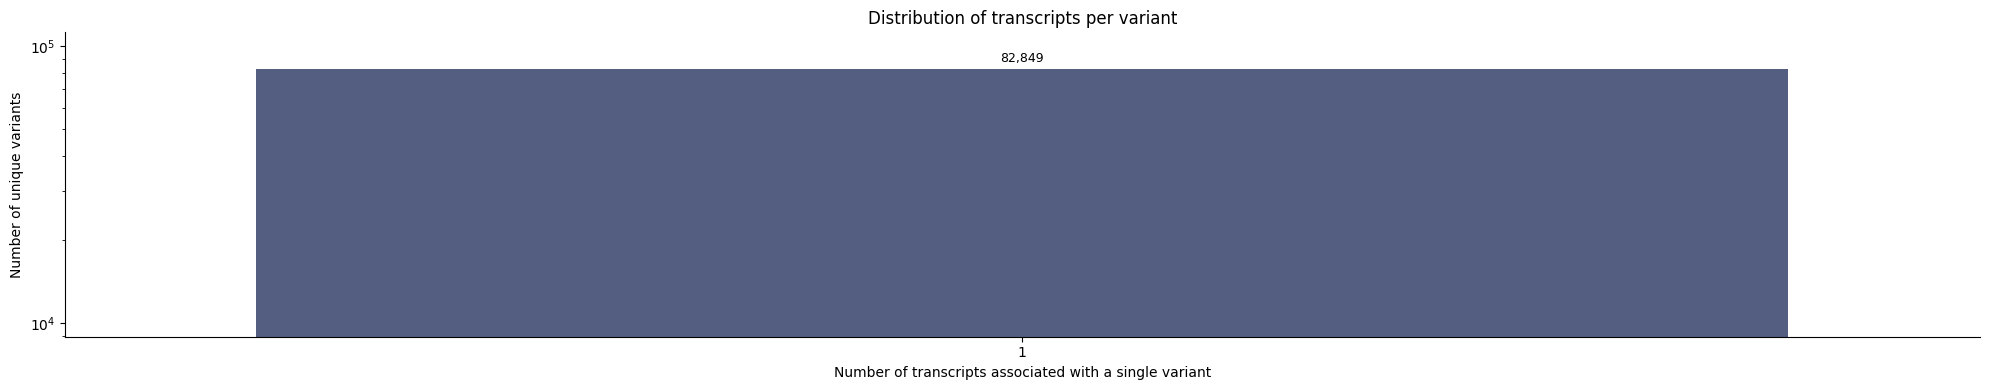

In [30]:
plot_transcript_distribution(merged)

In [31]:
merged.to_csv(f"{OUTPUT_DIR}/alphamissense_clinvar_processed.csv", index=False)

# 3. Cancer Hotspot

In [32]:
dataset_name = "alphamissense_data"
variants = pd.read_csv(f"{DATA_DIR}/{dataset_name}/alphamissense_cancer_hotspot.csv")
variants.head(2)

,variant_id,transcript_id,protein_variant,AlphaMissense,label
0,chr15_40382900_G_A_hg38,ENST00000249776.12,Q9Y448:C22Y,0.086676,1
1,chr12_913902_C_T_hg38,ENST00000430095.6,P43351:R396H,0.056817,1


In [ ]:
# Get the reference sequence and CDS context annotation of the variants from the GTF annotation and FASTA files #
# Using same annotation file that the authors used

## Extract assembly from first variant_id (e.g. chr1_925969_C_T_hg38 -> hg38)
assembly = variants["variant_id"].iloc[0].split("_")[-1]
assert assembly == "hg38"
## Extract genomic coordinates from the variant_id
variants[["chrom", "pos", "ref", "alt"]] = variants["variant_id"].str.extract(
    r"(chr\d+|chrX|chrY)_(\d+)_([ACGT])_([ACGT])"
)
variants["pos"] = variants["pos"].astype(int)
variants = variants.sort_values(by=["chrom", "pos"]).reset_index(drop=True).reset_index()
## Remove version numbers after dot in transcript_id
variants["transcript_id"] = variants["transcript_id"].str.split(".").str[0]
## Get the CDS sequences and annotations from the GTF and FASTA files
gtf_s, fasta = process_gtf(f"{DATA_DIR}/ucsc_gencodev32_hg38.tsv", f"{DATA_DIR}/reference/{assembly}/{assembly}.fa")
print(f"Processed {gtf_s.shape[0]} GTF CDS sequences")
display(gtf_s[["name", "chrom", "strand", "cdsStart", "cdsEnd", "cds_starts", "cds_ends", "cds_length"]].head(2))

In [34]:
# Process variants per chromosome
all_results = []
# Filter sequences with CDS length not multiple of 3
gtf_s = gtf_s[gtf_s["cds_length"].astype(int) % 3 == 0]
chroms = variants["chrom"].unique()
for chrom in tqdm(chroms, desc="Processing chromosomes", total=len(chroms)):
    curr_variants = (
        variants[variants["chrom"] == chrom][["variant_id", "chrom", "pos", "ref", "alt"]].drop_duplicates().copy()
    )
    chrom_gtf = gtf_s[gtf_s["chrom"] == chrom]
    chrom_results = process_a_chrom(curr_variants, chrom_gtf, return_alt_cds=True)
    all_results.append(chrom_results)
all_results = pd.concat(all_results).reset_index(drop=True)
all_results["variant_id"] = all_results["variant_id"] + "_" + assembly
all_results = all_results.merge(
    variants.drop("variant_id", axis=1),
    left_on=["chrom", "pos", "ref", "alt"],
    right_on=["chrom", "pos", "ref", "alt"],
)
print(f"\n Processed {all_results.shape[0]} mutations with CDS context:")
cols_to_display = [
    "chrom",
    "pos",
    "variant_id",
    "ref",
    "alt",
    "tx_name",
    "cdsStart",
    "cdsEnd",
    "tx_strand",
    "var_rel_dist_in_cds",
    "ref_codon",
    "alt_codon",
    "ref_aa",
    "alt_aa",
    "codon_position",
    "index",
    "transcript_id",
    "protein_variant",
    "AlphaMissense",
    "label",
]
display(all_results[cols_to_display].head(2))

Processing chromosomes: 100%|██████████| 23/23 [00:00<00:00, 66.11it/s]


 Processed 11615 mutations with CDS context:


,chrom,pos,variant_id,ref,alt,tx_name,cdsStart,cdsEnd,tx_strand,var_rel_dist_in_cds,ref_codon,alt_codon,ref_aa,alt_aa,codon_position,index,transcript_id,protein_variant,AlphaMissense,label
0,chr1,2557810,chr1_2557810_G_A_hg38,G,A,ENST00000409119,2556664,2561524,+,153,GAG,AAG,E,K,51,0,ENST00000355716,Q92956:E52K,0.232843,0
1,chr1,2558346,chr1_2558346_A_G_hg38,A,G,ENST00000409119,2556664,2561524,+,181,TAT,TGT,Y,C,60,1,ENST00000355716,Q92956:Y61C,0.839032,0


In [35]:
# Ensure reference allele in fasta matches reference allele in variants
for i in range(variants.shape[0]):
    t = variants.iloc[i]
    variant_id = t["variant_id"]
    chrom = t["chrom"]
    pos = t["pos"]
    ref = t["ref"]
    hg_ref = fasta[chrom][pos - 1]
    if hg_ref != ref:
        print(f"Mismatch at {chrom}:{pos}, {ref} != {hg_ref}, {variant_id}")

In [36]:
merged = variants.merge(
    all_results,
    left_on=["transcript_id", "variant_id", "chrom", "pos", "ref", "alt"],
    right_on=["tx_name", "variant_id", "chrom", "pos", "ref", "alt"],
    suffixes=("", "_y"),
)
merged.rename(columns={"index": "id"}, inplace=True)
merged.head(2)

,id,variant_id,transcript_id,protein_variant,AlphaMissense,label,chrom,pos,ref,alt,...,alt_codon,ref_aa,alt_aa,alt_seq,codon_position,index_y,transcript_id_y,protein_variant_y,AlphaMissense_y,label_y
0,0,chr1_2557810_G_A_hg38,ENST00000355716,Q92956:E52K,0.232843,0,chr1,2557810,G,A,...,AAG,E,K,ATGGAGCCTCCTGGAGACTGGGGGCCTCCTCCCTGGAGATCCACCC...,51,0,ENST00000355716,Q92956:E52K,0.232843,0
1,1,chr1_2558346_A_G_hg38,ENST00000355716,Q92956:Y61C,0.839032,0,chr1,2558346,A,G,...,TGT,Y,C,ATGGAGCCTCCTGGAGACTGGGGGCCTCCTCCCTGGAGATCCACCC...,60,1,ENST00000355716,Q92956:Y61C,0.839032,0


In [37]:
merged["label"].value_counts()

label
0    1733
1     868
Name: count, dtype: int64

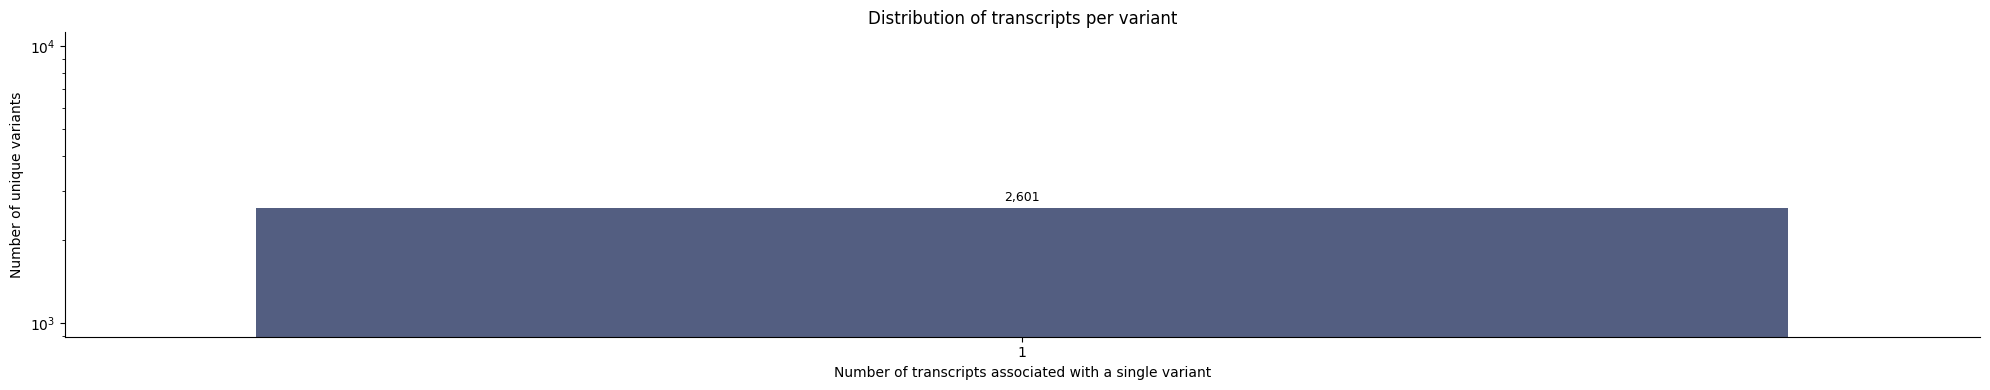

In [38]:
plot_transcript_distribution(merged)

In [39]:
merged.to_csv(f"{OUTPUT_DIR}/alphamissense_cancer_hotspot_processed.csv", index=False)

# 4. ClinVar Synonymous

In [7]:
dataset_name = "clinvar_synom"

# Get the synonymous variants from Clinvar
data = pd.read_table(f"{DATA_DIR}/clinvar_syn/variant_summary.txt.gz", low_memory=False)
data.iloc[:, 18] = data.iloc[:, 18].astype(str)
data = pl.from_pandas(data)
data = data.rename({"#AlleleID": "AlleleID"})
data = data.filter(
    (pl.col("Type") == "single nucleotide variant")
    & (pl.col("Assembly") == "GRCh38")
    & (
        pl.col("ReviewStatus").is_in(
            [
                "practice guideline",
                "reviewed by expert panel",
                "criteria provided, multiple submitters, no conflicts",
            ]
        )
    )
)
# normalize ref and alt
data = data.with_columns(
    ("chr" + pl.col("Chromosome")).alias("chrom"),
    pl.col("PositionVCF").alias("pos"),
    pl.col("ReferenceAlleleVCF").alias("ref"),
    pl.col("AlternateAlleleVCF").alias("alt"),
)

# filter synonymous variants
valid_chroms = ["chr" + str(i) for i in range(1, 23)]
clinvar_syn = data.filter(pl.col("Name").str.ends_with("=)")).filter(pl.col("ref") != pl.col("alt"))
clinvar_syn = clinvar_syn.filter(pl.col("chrom").is_in(valid_chroms))

# Label variants as benign or pathogenic
benign_labels = [
    "Benign",
    "Likely benign",
    "Benign/Likely benign",
]
patho_labels = ["Likely pathogenic", "Pathogenic", "Pathogenic/Likely pathogenic"]
clinvar_syn = clinvar_syn.filter(pl.col("ClinicalSignificance").is_in(benign_labels + patho_labels))


clinvar_syn.head(2)

AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,chrom,pos,ref,alt
i64,str,str,i64,str,str,str,i64,str,i64,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str
15111,"""single nucleotide variant""","""NM_000374.5(UROD):c.942G>A (p.…",7389,"""UROD""","""HGNC:12591""","""Likely pathogenic""",1,"""Apr 06, 2024""",121918062,"""-""","""RCV000000090|RCV001851503|RCV0…","""MONDO:MONDO:0008296,MedGen:C02…","""Familial porphyria cutanea tar…","""germline""","""germline""","""GRCh38""","""NC_000001.11""","""1""",45015006,45015006,"""na""","""na""","""1p34.1""","""criteria provided, multiple su…",3,"""-""","""N""","""ClinGen:CA251376,OMIM:613521.0…",3,72,45015006,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV002265299|SCV004109541""","""-""","""-""","""chr1""",45015006,"""G""","""A"""
15200,"""single nucleotide variant""","""NM_000274.4(OAT):c.1134C>T (p.…",4942,"""OAT""","""HGNC:8091""","""Benign""",0,"""Feb 03, 2025""",11461,"""-""","""RCV000380778|RCV000831333|RCV0…","""MONDO:MONDO:0009796,MedGen:C00…","""Ornithine aminotransferase def…","""germline;unknown""","""germline""","""GRCh38""","""NC_000010.11""","""10""",124400865,124400865,"""na""","""na""","""10q26.13""","""criteria provided, multiple su…",10,"""-""","""N""","""ClinGen:CA113955,OMIM:613349.0…",3,161,124400865,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000361341|SCV000973075|SCV0…","""-""","""-""","""chr10""",124400865,"""G""","""A"""


In [12]:
# Get the reference sequence and CDS context annotation of the variants from the GTF and FASTA files
refseq = pl.read_csv(f"{DATA_DIR}/clinvar_syn/ucsc_refseq_hg38.tsv", separator="\t")
refseq.head(2)

# Build CDS sequences for synonymous variants
valid_chroms = ["chr" + str(i) for i in range(1, 23)]
refseq = pl.read_csv(f"{DATA_DIR}/clinvar_syn/ucsc_refseq_hg38.tsv", separator="\t")
refseq_hist = pl.read_csv(f"{DATA_DIR}/clinvar_syn/ucsc_refseq_hist_hg38.tsv", separator="\t")
refseq = pl.concat([refseq, refseq_hist])
refseq = refseq.filter(pl.col("chrom").is_in(valid_chroms)).unique()
fasta = {}

with pyfaidx.Fasta(f"{DATA_DIR}/reference/hg38/hg38.fa") as f:
    for chrom in refseq["chrom"].unique():
        fasta[chrom] = f[chrom][:].seq
refseq = refseq.with_columns(
    pl.struct(pl.all())
    .map_elements(lambda row: extract_cds_sequence(row, fasta), return_dtype=pl.String)
    .alias("cds_sequence")
).filter(pl.col("cds_sequence").str.len_chars() % 3 == 0)
refseq.head(2)

#bin,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames,cds_sequence
i64,str,str,str,i64,i64,i64,i64,i64,str,str,i64,str,str,str,str,str
14,"""NM_021079.5""","""chr17""","""+""",45061316,45109016,45061329,45105639,12,"""45061316,45081643,45086507,450…","""45061460,45081752,45086652,450…",0,"""NMT1""","""cmpl""","""cmpl""","""0,2,0,1,0,2,2,2,0,0,0,0,""","""ATGGCGGACGAGAGTGAGACAGCAGTGAAG…"
1010,"""NR_026723.1""","""chr12""","""-""",55752462,55817756,55817756,55817756,12,"""55752462,55757382,55760550,557…","""55752840,55757553,55760640,557…",0,"""CIP29""","""none""","""none""","""-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,…",""""""


In [13]:
# Add splicing junction information
splicing_juncs = []
for row in refseq.iter_rows(named=True):
    exon_starts = row["exonStarts"].strip(",").split(",")
    exon_ends = row["exonEnds"].strip(",").split(",")
    exon_starts = [int(i) for i in exon_starts]
    exon_ends = [int(i) for i in exon_ends]
    for i in range(1, len(exon_starts)):
        splicing_juncs.append([row["name"], row["chrom"], row["strand"], exon_starts[i] - 2, exon_starts[i] + 2])
    for i in range(0, len(exon_ends) - 1):
        splicing_juncs.append([row["name"], row["chrom"], row["strand"], exon_ends[i] - 2, exon_ends[i] + 2])
splicing_juncs = pd.DataFrame(splicing_juncs, columns=["tx", "chrom", "strand", "start", "end"])
splicing_juncs = pl.from_pandas(splicing_juncs)

# Extract all unique transcripts first
unique_tx = clinvar_syn["Name"].str.split(":").list.get(0).str.split("(").list.get(0).unique()
# Create a dictionary mapping transcripts to their junction ranges
tx_junc_dict = {}
for tx in unique_tx:
    tx_juncs = splicing_juncs.filter(pl.col("tx") == tx)
    if len(tx_juncs) > 0:
        tx_junc_dict[tx] = {"starts": tx_juncs["start"].to_numpy(), "ends": tx_juncs["end"].to_numpy()}


def check_splice_junction_fast(variant):
    tx = variant["Name"].split(":")[0].split("(")[0]
    # if tx not in tx_junc_dict:
    #     return False
    juncs = tx_junc_dict[tx]
    return np.any((variant["pos"] - 1 >= juncs["starts"]) & (variant["pos"] - 1 < juncs["ends"]))


tx_gposes = {}
for row in refseq.rows(named=True):
    curr_poses = []
    chrom = row["chrom"]
    strand = row["strand"]
    cds_start = row["cdsStart"]
    cds_end = row["cdsEnd"]

    # Parse exon coordinates
    exon_starts = [int(x) for x in row["exonStarts"].rstrip(",").split(",")]
    exon_ends = [int(x) for x in row["exonEnds"].rstrip(",").split(",")]
    for start, end in zip(exon_starts, exon_ends):
        # Find overlap between exon and CDS
        overlap_start = max(start, cds_start)
        overlap_end = min(end, cds_end)
        for i in range(overlap_start, overlap_end):
            curr_poses.append(i)
    if strand == "-":
        curr_poses = curr_poses[::-1]
    tx_gposes[(row["chrom"], row["name"])] = curr_poses

dset = clinvar_syn.with_columns(pl.col("Name").str.split(":").list.get(0).str.split("(").list.get(0).alias("tx"))
dset = dset.filter(pl.col("tx").is_in(tx_junc_dict.keys()))
dset = dset.with_columns(
    pl.struct(pl.all()).map_elements(check_splice_junction_fast, return_dtype=pl.Boolean).alias("in_splice_junction")
)

dset.head(2)

AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,chrom,pos,ref,alt,tx,in_splice_junction
i64,str,str,i64,str,str,str,i64,str,i64,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,bool
15111,"""single nucleotide variant""","""NM_000374.5(UROD):c.942G>A (p.…",7389,"""UROD""","""HGNC:12591""","""Likely pathogenic""",1,"""Apr 06, 2024""",121918062,"""-""","""RCV000000090|RCV001851503|RCV0…","""MONDO:MONDO:0008296,MedGen:C02…","""Familial porphyria cutanea tar…","""germline""","""germline""","""GRCh38""","""NC_000001.11""","""1""",45015006,45015006,"""na""","""na""","""1p34.1""","""criteria provided, multiple su…",3,"""-""","""N""","""ClinGen:CA251376,OMIM:613521.0…",3,72,45015006,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV002265299|SCV004109541""","""-""","""-""","""chr1""",45015006,"""G""","""A""","""NM_000374.5""",true
15200,"""single nucleotide variant""","""NM_000274.4(OAT):c.1134C>T (p.…",4942,"""OAT""","""HGNC:8091""","""Benign""",0,"""Feb 03, 2025""",11461,"""-""","""RCV000380778|RCV000831333|RCV0…","""MONDO:MONDO:0009796,MedGen:C00…","""Ornithine aminotransferase def…","""germline;unknown""","""germline""","""GRCh38""","""NC_000010.11""","""10""",124400865,124400865,"""na""","""na""","""10q26.13""","""criteria provided, multiple su…",10,"""-""","""N""","""ClinGen:CA113955,OMIM:613349.0…",3,161,124400865,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000361341|SCV000973075|SCV0…","""-""","""-""","""chr10""",124400865,"""G""","""A""","""NM_000274.4""",false


In [ ]:
# Process variants per chromosome and add additional features: pLI, PhyloP, codon frequencies
import re


result = []

for row in tqdm(dset.rows(named=True)):
    s = row["Name"].split(":")[1].split(" ")[0]
    m = re.fullmatch(r"c\.(\d+)([ACGT])>([ACGT])", s)
    pos_cds, ref_cds, alt_cds = int(m.group(1)), m.group(2), m.group(3)

    tx = refseq.filter((pl.col("name") == row["tx"]) & (pl.col("chrom") == row["chrom"]))[0]
    try:
        pos_cds0 = tx_gposes[(row["chrom"], row["tx"])].index(row["pos"] - 1)
    except:
        continue
    seq = tx[0, "cds_sequence"]
    if pos_cds0 + 1 != pos_cds:
        print(str(row))
    assert seq[pos_cds0] == ref_cds
    assert ref_cds == row["ref"] if tx[0, "strand"] == "+" else get_reverse_complement(row["ref"])
    assert alt_cds == row["alt"] if tx[0, "strand"] == "+" else get_reverse_complement(row["alt"])

    codon_position = pos_cds0 // 3
    ref_codon = seq[codon_position * 3 : (codon_position + 1) * 3]
    remainder = pos_cds0 % 3
    alt_nuc = list(ref_codon)
    alt_nuc[remainder] = alt_cds
    alt_codon = "".join(alt_nuc)
    item = {
        "chrom": row["chrom"],
        "pos": row["pos"],
        "ref": row["ref"],
        "alt": row["alt"],
        "var_rel_dist_in_cds": pos_cds0,
        "codon_position": codon_position,
        "ref_codon": ref_codon,
        "alt_codon": alt_codon,
        "tx": row["tx"],
        "label": row["ClinicalSignificance"],
        "in_splice_junction": row["in_splice_junction"],
        "ref_seq": seq,
        "alt_seq": seq[:pos_cds0] + alt_cds + seq[pos_cds0 + 1 :],
    }
    result.append(item)


result_df = pl.from_dicts(result).with_row_index("id")
frame = result_df.to_pandas()
(frame["ref_seq"].apply(lambda x: len(x) == 0)).sum()

In [18]:
print("Adding additional features (pLI, PhyloP, codon frequencies)...")
dset = process_dset(result_df, refseq, remove_non_pli=False)
print(f"Dataset with additional features: {dset.shape[0]} variants")
dset.head(2)

Adding additional features (pLI, PhyloP, codon frequencies)...


100%|███████████████████████████████████████████████████████████| 129384/129384 [00:12<00:00, 10168.75it/s]


Dataset with additional features: 129384 variants


id,chrom,pos,ref,alt,var_rel_dist_in_cds,codon_position,ref_codon,alt_codon,tx,label,in_splice_junction,ref_seq,alt_seq,ref_aa,alt_aa,ref_codon_freq,alt_codon_freq,codon_freq_ratio,gene_name,pli,pli_bin,phylop,phylop_bin,cds_length,cds_offset_frac,cds_offset_frac_bin
u32,str,i64,str,str,i64,i64,str,str,str,str,bool,str,str,str,str,f64,f64,f64,str,f64,i32,f64,i32,u32,f64,i32
0,"""chr1""",45015006,"""G""","""A""",941,313,"""GAG""","""GAA""","""NM_000374.5""","""Likely pathogenic""",true,"""ATGGAAGCGAATGGGTTGGGACCTCAGGGT…","""ATGGAAGCGAATGGGTTGGGACCTCAGGGT…","""E""","""E""",4.6414453e7,3.7827281e7,0.20458,"""UROD""",0.0,0,7.998,8,1104,0.852355,8
1,"""chr10""",124400865,"""G""","""A""",1133,377,"""AAC""","""AAT""","""NM_000274.4""","""Benign""",false,"""ATGTTTTCCAAACTAGCACATTTGCAGAGG…","""ATGTTTTCCAAACTAGCACATTTGCAGAGG…","""N""","""N""",2.0900468e7,2.0353876e7,0.0265,"""OAT""",0.0,0,-2.351,-2,1320,0.858333,8


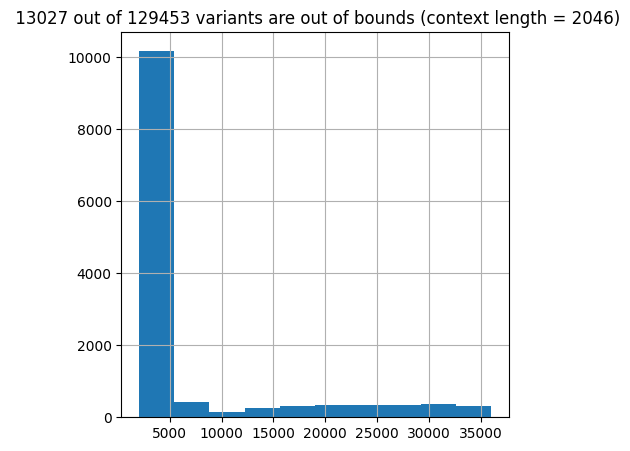

In [19]:
context_to_check = 2046
checks = check_mutation_positions(result_df.to_pandas(), context_to_check)
checks[checks["out_of_bounds"]].codon_position.hist(figsize=(5, 5))
plt.title(
    f" {checks['out_of_bounds'].sum()} out of {len(checks)} variants are out of bounds (context length = {context_to_check})"
)
plt.show()

In [20]:
# Save processed results, dset, and refseq tables
dset.write_csv(f"{OUTPUT_DIR}/clinvar_synom.csv")